In [55]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter
import pylab as P
listing='C:\Users\\12815\\Desktop\\DataSet\\listings.csv'
cols = ['price',
        'accommodates',
        'bedrooms',
        'beds',
        'neighbourhood_cleansed',
        'room_type',
        'cancellation_policy',
        'instant_bookable',
        'reviews_per_month',
        'number_of_reviews',
        'availability_30',
        'review_scores_rating',
#         'property_type',
#         'bed_type',
#         'cleaning_fee',
        ]
#read the file into a dataframe
df=pd.read_csv(listing, usecols=cols)
df.info()
df.describe()
#df['price'][0:10]
#df.price[0:10]
#type(df['price'])
#df['Age'].mean()
#df[['price', 'number_of_reviews', 'property_type']]
#df[df['price']>100]
#df[df['price']>100]['property_type', 'cleaning_fee']
#for i in range(1,4):  
#    print i, len(df[ (df['Sex'] == 'male') & (df['Pclass'] == i) ])
# df['price'].hist()
# P.show()
# df['number_of_reviews'].dropna().hist(bins=16, range=(0,200), alpha=.5)
# P.show()
# df.dtypes
# df['Gender']=4
# df['Gender']=df['sex'].map(lambda x: x[0].upper)  这样变为Sex的首字母大写形式
# df['Gender']=df['sex'],map({'female':0, 'male': 1}).astype(int)
#因为大部分机器学习需要一个完整的特征列， 现在我们需要处理Age中缺失的数据。 如果我们随便
#猜测数据填进去， 这就相当于向模型中加入了一些噪音， 但如果我们猜测是有根据的， 一些值是接近
#历史事实的， 那么模型的效果必然是比随机猜测要好。
# df.dftypes[df.dtypes.map(lambda x: x=='object')]
# df=df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1)
# df= df.dropna() 去除所有有缺失值的行
# train_data=df.values  将其转化为Numpy数组
# data=pd.read_csv("train.csv", index_col="Loan_ID")
# data.loc[(data["Gender"]=="Female") &(data["Education"]=="Not Graduate") &(data["Loan_Status"]=="Y"), ["Gender", "Education","Loan_Status"]]
# def num_missing(x):
# return sum(x.isnull())
# Apply 到每一列：
# print "Missing values per column:"
# print data.apply(num_missing, axis=0)
# print '\n Missing values per row:'
# print data.apply(num_missing, axis=1).head()
# fillna() 可以用来解决缺失值的问题， 它被用来把缺失值替换为所在列的平均值/众数/中位数
# from scipy.stats import mode
# mode(data['Gender']).mode[0] 众数
# 上面的函数返回了及其出现次数， 记住总数可以是个数组， 因为高频的值可能不只一个
#  Pandas can be used to create pivot table
# impute_grps= data.pivot_table(values=["LoanAmount"], index=["Gender", "Married", "Self_Employed"], aggfunc=np.mean)
# print impute_grps
#data_sorted = data.sort_values(['ApplicantIncome','CoapplicantIncome'], ascending=False)

#data_sorted[['ApplicantIncome','CoapplicantIncome']].head(10)
print len(df.index)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40227 entries, 0 to 40226
Data columns (total 12 columns):
neighbourhood_cleansed    40227 non-null object
room_type                 40227 non-null object
accommodates              40227 non-null int64
bedrooms                  40170 non-null float64
beds                      40158 non-null float64
price                     40227 non-null object
availability_30           40227 non-null int64
number_of_reviews         40227 non-null int64
review_scores_rating      30420 non-null float64
instant_bookable          40227 non-null object
cancellation_policy       40227 non-null object
reviews_per_month         31150 non-null float64
dtypes: float64(4), int64(3), object(5)
memory usage: 3.7+ MB
40227


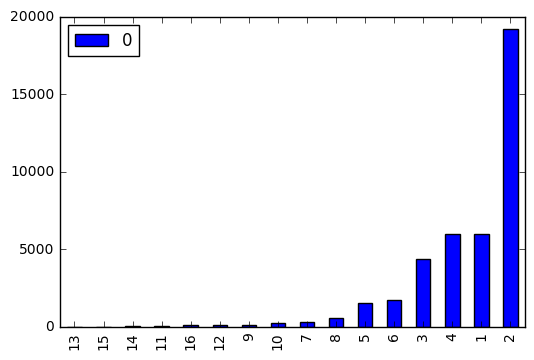

In [56]:
nb_counts = Counter(df.accommodates)
# nb_counts_neighbourhood_cleansed=Counter(df.neighbourhood_cleansed)

# print nb_counts
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar')

In [57]:
len(df[(df.number_of_reviews==0) &(pd.isnull(df.number_of_reviews)==False) 
       &(pd.isnull(df.reviews_per_month)==False)].index)

0

In [58]:
len(df[(df.number_of_reviews != 0) & (pd.isnull(df.number_of_reviews) == False)
       & (pd.isnull(df.reviews_per_month) == True)].index)

69

In [59]:
df['reviews_per_month'].fillna(0, inplace=True)

In [60]:
len(df[(df.number_of_reviews != 0) & (pd.isnull(df.number_of_reviews) == False)
       & (pd.isnull(df.reviews_per_month) == True)].index)

0

In [61]:
df = df[df.bedrooms != 0]
df = df[df.beds != 0]
df = df[df.price != 0]
df = df.dropna(axis=0)

In [62]:
len(df.index)

27735

In [63]:
df = df[df.bedrooms == 1]
len(df.index)

22833

In [64]:
# remove the $ from the price and convert to float
df['price'] = df['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)
df.price.head(5)
df=df[df.price<=1000]
len(df.index)

22811

In [65]:
# get feature encoding for categorical variables
n_dummies = pd.get_dummies(df.neighbourhood_cleansed)
rt_dummies = pd.get_dummies(df.room_type)
xcl_dummies = pd.get_dummies(df.cancellation_policy)
# convert boolean column to a single boolean value indicating whether this listing has instant booking available
ib_dummies = pd.get_dummies(df.instant_bookable, prefix="instant")
ib_dummies = ib_dummies.drop('instant_f', axis=1)
# replace the old columns with our new one-hot encoded ones
alldata = pd.concat((df.drop(['neighbourhood_cleansed', \
    'room_type', 'cancellation_policy', 'instant_bookable'], axis=1), \
    n_dummies.astype(int), rt_dummies.astype(int), \
    xcl_dummies.astype(int), ib_dummies.astype(int)), \
    axis=1)
allcols = alldata.columns
alldata.head(5)

,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,reviews_per_month,Allerton,Arden Heights,...,Woodlawn,Woodside,Entire home/apt,Private room,Shared room,flexible,moderate,strict,super_strict_30,instant_t
0,2,1.0,1.0,75.0,4,145,92.0,2.87,0,0,...,0,0,1,0,0,0,0,1,0,0
1,5,1.0,2.0,117.0,3,50,94.0,4.27,0,0,...,0,0,1,0,0,0,0,1,0,0
2,2,1.0,1.0,89.0,3,43,95.0,1.81,0,0,...,0,0,0,1,0,1,0,0,0,0
4,4,1.0,1.0,200.0,8,1,100.0,1.00,0,0,...,0,0,1,0,0,1,0,0,0,0
6,1,1.0,1.0,119.0,4,1,89.0,0.02,0,0,...,0,0,0,1,0,0,0,1,0,0


1000.0
       accommodates  bedrooms  beds   price  availability_30  \
9435              2       1.0   1.0  1000.0               28   
10660             2       1.0   1.0  1000.0               30   
20238             4       1.0   1.0  1000.0               23   
21841             2       1.0   1.0  1000.0               15   
27814            16       1.0   1.0  1000.0               30   
32280             2       1.0   1.0  1000.0               10   

       number_of_reviews  review_scores_rating  reviews_per_month  Allerton  \
9435                   2                  80.0               0.39         0   
10660                 15                  93.0               0.50         0   
20238                  7                  94.0               0.82         0   
21841                 30                  92.0               0.41         0   
27814                  3                  93.0               0.64         0   
32280                  6                  97.0               0.21     

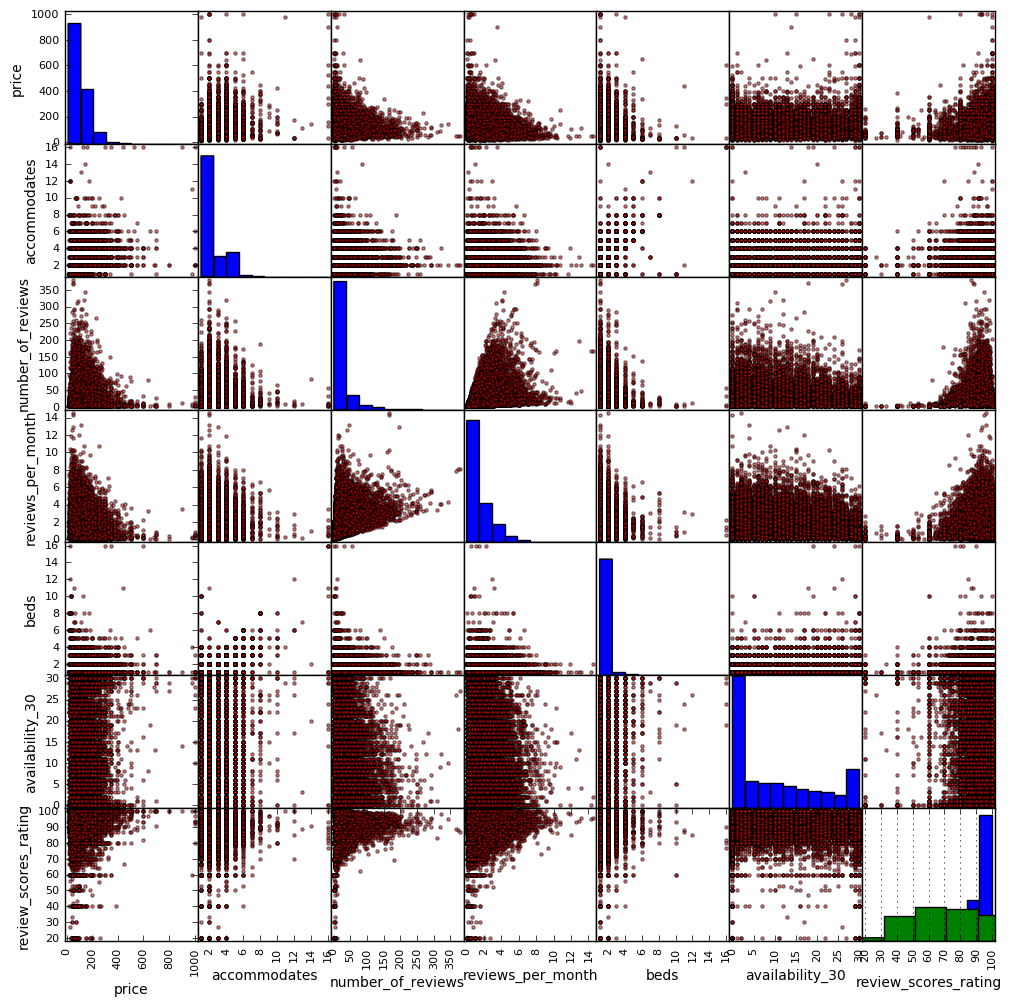

In [95]:
scattercols = ['price','accommodates', 'number_of_reviews', 'reviews_per_month', 'beds', 'availability_30', 'review_scores_rating']
axs = pd.scatter_matrix(alldata[scattercols],
                        figsize=(12, 12), c='red')
print alldata.price.max()
print alldata[alldata.price==alldata.price.max()]
print alldata.price.min()
alldata['price'].hist(bins=50)
print

Linear  got error 19.56
Ridge  got error 19.50
Lasso  got error 25.88
ElasticNet  got error 31.02
BayesRidge  got error 19.40
OMP got error 21.26


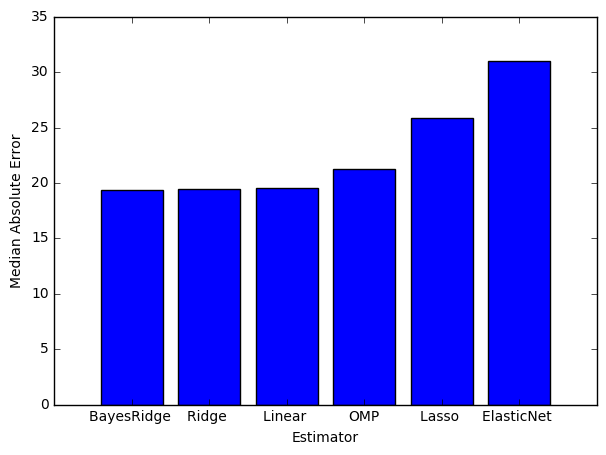

In [71]:
rs = 1
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear ', 'Ridge ', 'Lasso ', 
                        'ElasticNet ', 'BayesRidge ', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test = train_test_split(alldata.drop(['price'], axis=1),
                                                    alldata.price, test_size=0.2, random_state=20)
index=0
for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    print ests_labels[index]+" got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)
    index+=1

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

In [86]:
n_est = 300


tuned_parameters = {
    "n_estimators": [1500],
    "max_depth" : [  4 ],
    "learning_rate": [ 0.02],
    "min_samples_split" : [ 2],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='median_absolute_error')

preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
best

C:\Users\12815\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\12815\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\12815\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\12815\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\128

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.02, loss='lad', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [84]:
# tuned_parameters = {
#     "n_estimators": [ n_est ],
#     "max_depth" : [ 4 ],
#     "learning_rate": [ 0.01 ],
#     "min_samples_split" : [ 2 ],
#     "loss" : [ 'ls', 'lad' ]
# }
# gbr = ensemble.GradientBoostingRegressor()
# clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
#         scoring='median_absolute_error')
# preds = clf.fit(X_train, y_train)
# best = clf.best_estimator_
abs(clf.best_score_)

C:\Users\12815\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\12815\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\12815\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\12815\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\128

17.34199425157995

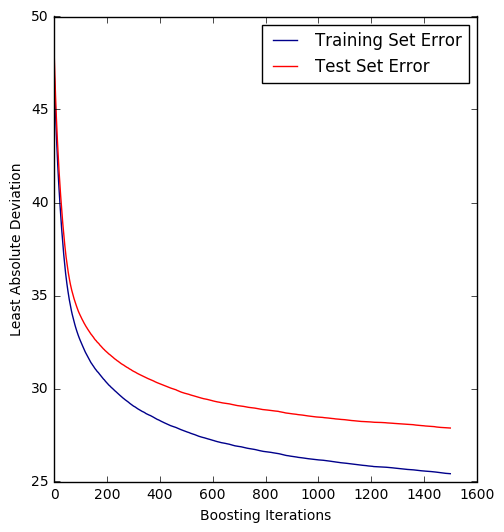

In [87]:
# plot error for each round of boosting
n_est=1500
test_score = np.zeros(n_est, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')

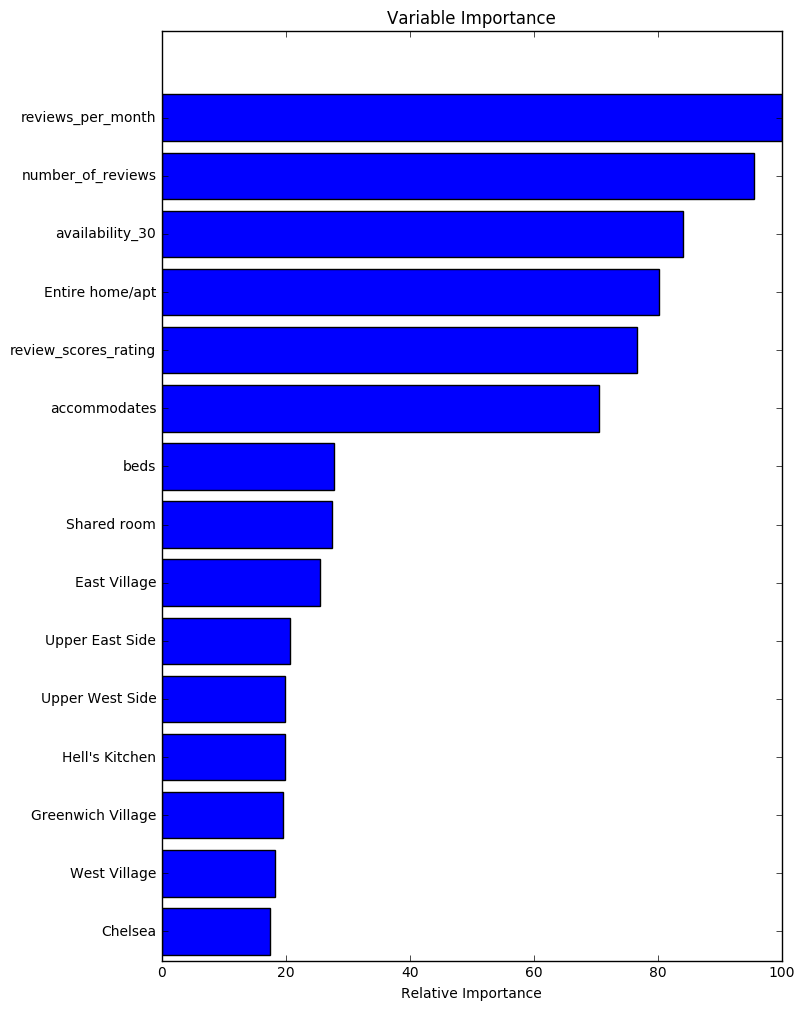

In [94]:
feature_importance = clf.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx=sorted_idx[-15:]
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')